In [1]:
import os 
import opendssdirect as dss
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import numpy as np
import arviz as az
import networkx as nx
import pandapower as pp
import pandapower.networks as pn

from scipy.stats import norm
from xarray_einstats.stats import XrContinuousRV
import math
import pytensor
import pickle
import copy
import random

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#num_single_loads
#num_three_phase_loads
#phases_planning
#phases_proportion

def generate_3_phase_model(graph_from_net,aggregated_power_dict,prob_three_phases_dict,phases_proportion,p_phases_choice):
    with pm.Model() as three_phase_model:
        feeder_idx=0


        # proportion of each phase
        num_total_loads=len(graph_from_net.nodes)
        #num_total_loads=5
        #num_total_loads=int(num_single_loads[feeder_idx]+num_three_phase_loads[feeder_idx])
        #prop_three_phase=num_three_phase_loads[feeder_idx]/num_total_loads
        prob_three_phases_data=list(prob_three_phases_dict.values())
        #prob_three_phase=0

        three_phase_choice=pm.Bernoulli('three_phase_choice',p=prob_three_phases_data,shape=num_total_loads)



        mu_prop_a=np.mean([phases_proportion[idx][0] for idx in range(len(phases_proportion))])
        #var_prop_a=np.std([phases_proportion[idx][0] for idx in range(len(phases_proportion))])
        #prop_a=pm.TruncatedNormal('prop_a',mu=mu_prop_a,sigma=var_prop_a,shape=num_total_loads,lower=0)

        mu_prop_b=np.mean([phases_proportion[idx][1] for idx in range(len(phases_proportion))])
        #var_prop_b=np.std([phases_proportion[idx][1] for idx in range(len(phases_proportion))])
        #prop_b=pm.TruncatedNormal('prop_b',mu=mu_prop_b,sigma=var_prop_b,shape=num_total_loads,lower=0)

        mu_prop_c=np.mean([phases_proportion[idx][2] for idx in range(len(phases_proportion))])
        #var_prop_c=np.std([phases_proportion[idx][2] for idx in range(len(phases_proportion))])
        #prop_c=pm.TruncatedNormal('prop_c',mu=mu_prop_c,sigma=var_prop_c,shape=num_total_loads,lower=0)

        # phase choice


        phase_choice=pm.Categorical('phase_choice',p=p_phases_choice,shape=(num_total_loads))


        # defining load of each phase
        #mu_p_a=np.mean([phases_planning[idx][0] for idx in range(len(phases_planning))])
        mu_p_a=np.array(list(aggregated_power_dict.values()))
        normalizing_constant=[phases_planning[idx][0] for idx in range(len(phases_planning))]/max([phases_planning[idx][0] for idx in range(len(phases_planning))])
        var_p_a=np.std(normalizing_constant*np.max(list(aggregated_power_dict.values())))
        #expected_p_a=pm.Deterministic('mu_p_a',mu_p_a/(num_total_loads*(prop_three_phase*1/3+(1-prop_three_phase)*prop_a))) #phase a
        p_a=pm.TruncatedNormal('P_a',mu=mu_p_a,sigma=var_p_a,lower=0,shape=(num_total_loads))

        #mu_p_b=np.mean([phases_planning[idx][1] for idx in range(len(phases_planning))])
        mu_p_b=np.array(list(aggregated_power_dict.values()))
        normalizing_constant=[phases_planning[idx][1] for idx in range(len(phases_planning))]/max([phases_planning[idx][1] for idx in range(len(phases_planning))])
        var_p_b=np.std(normalizing_constant*np.max(list(aggregated_power_dict.values())))
        #expected_p_b=pm.Deterministic('mu_p_b',mu_p_b/(num_total_loads*(prop_three_phase*1/3+(1-prop_three_phase)*prop_b))) #phase b
        p_b=pm.TruncatedNormal('P_b',mu=mu_p_b,sigma=var_p_b,lower=0,shape=(num_total_loads))

        #mu_p_c=np.mean([phases_planning[idx][2] for idx in range(len(phases_planning))])
        mu_p_c=np.array(list(aggregated_power_dict.values()))
        normalizing_constant=[phases_planning[idx][2] for idx in range(len(phases_planning))]/max([phases_planning[idx][2] for idx in range(len(phases_planning))])
        var_p_c=np.std(normalizing_constant*np.max(list(aggregated_power_dict.values())))
        #expected_p_c=pm.Deterministic('mu_p_c',mu_p_c/(num_total_loads*(prop_three_phase*1/3+(1-prop_three_phase)*prop_c))) #phase c
        p_c=pm.TruncatedNormal('P_c',mu=mu_p_c,sigma=var_p_c,lower=0,shape=(num_total_loads))


        real_p_a=pm.Deterministic('real_p_a',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 0),p_a,0),p_a*mu_prop_a))
        real_p_b=pm.Deterministic('real_p_b',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 1),p_b,0),p_b*mu_prop_b))
        real_p_c=pm.Deterministic('real_p_c',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 2),p_c,0),p_c*mu_prop_c))



        power_factor_mu=0.95
        power_factor=pm.Beta('power_factor',mu=power_factor_mu,sigma=power_factor_mu*0.05,shape=num_total_loads)

        var_q_a=np.sqrt((var_p_a/power_factor_mu)**2-var_p_a**2)
        var_q_b=np.sqrt((var_p_b/power_factor_mu)**2-var_p_b**2)
        var_q_c=np.sqrt((var_p_c/power_factor_mu)**2-var_p_c**2)

        q_a=pm.TruncatedNormal('Q_a',mu=np.sqrt((mu_p_a/power_factor_mu)**2-mu_p_a**2),sigma=var_q_a,lower=0,shape=(num_total_loads))
        q_b=pm.TruncatedNormal('Q_b',mu=np.sqrt((mu_p_b/power_factor_mu)**2-mu_p_b**2),sigma=var_q_b,lower=0,shape=(num_total_loads))
        q_c=pm.TruncatedNormal('Q_c',mu=np.sqrt((mu_p_c/power_factor_mu)**2-mu_p_c**2),sigma=var_q_c,lower=0,shape=(num_total_loads))

        real_q_a=pm.Deterministic('real_q_a',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 0),q_a,0),q_a*mu_prop_a))
        real_q_b=pm.Deterministic('real_q_b',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 1),q_b,0),q_b*mu_prop_b))
        real_q_c=pm.Deterministic('real_q_c',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 2),q_c,0),q_c*mu_prop_c))

        #phases_planning[feeder_idx]
        #active_power_load=pm.Normal(mu=)
    return three_phase_model

In [3]:
def generate_power_data_df(three_phase_model):
    with three_phase_model:
        idata = pm.sample(draws=100,chains=4,tune=10)


    #generating df_dict
    [num_chains,num_samples,num_loads]=idata.posterior['P_a'].shape

    sample_idx=0

    df_dict={}

    load_list_a=[[] for k_idx in range(num_loads)]
    load_list_b=[[] for k_idx in range(num_loads)]
    load_list_c=[[] for k_idx in range(num_loads)]

    df_dict=pd.DataFrame(columns=['sample_idx','node','p_a','q_a','p_b','q_b','p_c','q_c','num_phases','distance'])
    real_p_a_array=copy.deepcopy(idata.posterior['real_p_a'].values)
    real_p_b_array=copy.deepcopy(idata.posterior['real_p_b'].values)
    real_p_c_array=copy.deepcopy(idata.posterior['real_p_c'].values)
    real_q_a_array=copy.deepcopy(idata.posterior['real_q_a'].values)
    real_q_b_array=copy.deepcopy(idata.posterior['real_q_b'].values)
    real_q_c_array=copy.deepcopy(idata.posterior['real_q_c'].values)
    three_phase_choice_array=copy.deepcopy(idata.posterior['three_phase_choice'].values)


    for i in range(num_chains): #chains
        print(i)
        for j in range(num_samples): #samples
            for k in range(num_loads):
                distance=normalized_dist_dict[k]
                phase_a_p=float(real_p_a_array[i][j][k])
                phase_a_q=float(real_q_a_array[i][j][k])
                phase_b_p=float(real_p_b_array[i][j][k])
                phase_b_q=float(real_q_b_array[i][j][k])
                phase_c_p=float(real_p_c_array[i][j][k])
                phase_c_q=float(real_q_c_array[i][j][k])
                num_phases=float(three_phase_choice_array[i][j][k])
                df_dict.loc[len(df_dict)]=[sample_idx,k,phase_a_p,phase_a_q,phase_b_p,phase_b_q,phase_c_p,phase_c_q,num_phases,distance]
        
            sample_idx+=1

    user_input_p=[]
    user_input_q=[]
    power_data_df=pd.DataFrame(columns=['source','power_type','phase','value'])
    error_dict={'p_a':[],
                'p_b':[],
                'p_c':[],
                'q_a':[],
                'q_b':[],
                'q_c':[],
                }


    user_input_p_a_list=[]
    for node_idx in graph_from_net.nodes:
        p_a=np.mean(df_dict[(df_dict.node==node_idx)].p_a)
        q_a=np.mean(df_dict[(df_dict.node==node_idx)].q_a)
        p_b=np.mean(df_dict[(df_dict.node==node_idx)].p_b)
        q_b=np.mean(df_dict[(df_dict.node==node_idx)].q_b)
        p_c=np.mean(df_dict[(df_dict.node==node_idx)].p_c)
        q_c=np.mean(df_dict[(df_dict.node==node_idx)].q_c)

        user_input_p_a=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].p_a_mw)
        user_input_p_b=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].p_b_mw)
        user_input_p_c=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].p_c_mw)
        user_input_q_a=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].q_a_mvar)
        user_input_q_b=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].q_b_mvar)
        user_input_q_c=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].q_c_mvar)

        #real data
        power_data_df.loc[len(power_data_df)]=['model','p','a',p_a]
        power_data_df.loc[len(power_data_df)]=['model','q','b',q_a]
        power_data_df.loc[len(power_data_df)]=['model','p','c',p_b]
        power_data_df.loc[len(power_data_df)]=['model','q','a',q_b]
        power_data_df.loc[len(power_data_df)]=['model','p','b',p_c]
        power_data_df.loc[len(power_data_df)]=['model','q','c',q_c]


        
        #user input
        if(user_input_p_a!=0):
            user_input_p_a_list.append(user_input_p_a)
            error_dict['p_a'].append(np.abs(((p_a-user_input_p_a)/user_input_p_a)))
            power_data_df.loc[len(power_data_df)]=['user_input','p','a',user_input_p_a]
        if(user_input_p_b!=0):
            power_data_df.loc[len(power_data_df)]=['user_input','p','b',user_input_p_b]
            error_dict['p_b'].append(np.abs(((p_b-user_input_p_b)/user_input_p_b)))
        if(user_input_p_c!=0):
            power_data_df.loc[len(power_data_df)]=['user_input','p','c',user_input_p_c]
            error_dict['p_c'].append(np.abs(((p_c-user_input_p_c)/user_input_p_c)))
        if(user_input_q_a!=0):
            power_data_df.loc[len(power_data_df)]=['user_input','q','a',user_input_q_a]
            error_dict['q_a'].append(np.abs(((q_a-user_input_q_a)/user_input_q_a)))
        if(user_input_q_b!=0):
            power_data_df.loc[len(power_data_df)]=['user_input','q','b',user_input_q_b]
            error_dict['q_b'].append(np.abs(((q_b-user_input_q_b)/user_input_q_b)))
        if(user_input_q_c!=0):
            power_data_df.loc[len(power_data_df)]=['user_input','q','c',user_input_q_c]
            error_dict['q_c'].append(np.abs(((q_c-user_input_q_c)/user_input_q_c)))

    return [power_data_df,error_dict]


# Gathered data (from oedi)

In [4]:
to_save_folder=r'C:\Users\hoc\Documents\Henrique\Doutorado\codigos_linux\dev\phd\papers\artigo_3_phase_synthetic\generated_data'

prob_3_phases=pickle.load(open(os.path.join(to_save_folder,'prob_3_phases.pickle'),'rb'))

phases_proportion=pickle.load(open(os.path.join(to_save_folder,'phases_proportion.pickle'),'rb'))

phases_planning=pickle.load(open(os.path.join(to_save_folder,'phases_planning.pickle'),'rb'))

power_df=pickle.load(open(os.path.join(to_save_folder,'power_df.pickle'),'rb'))

In [21]:
power_df

,profile_id,p_kw,q_kvar
0,41715,9.609767,3.317037
1,41715,9.971489,3.546905
2,41715,10.222439,3.664904
3,41715,9.546581,3.356791
4,41715,9.302362,3.265478
...,...,...,...
3645,41738,87.000511,25.324016
3646,41738,102.575203,26.747087
3647,41738,99.321566,26.366949
3648,41738,96.634361,25.750813


## Probability of 3 phases for loads

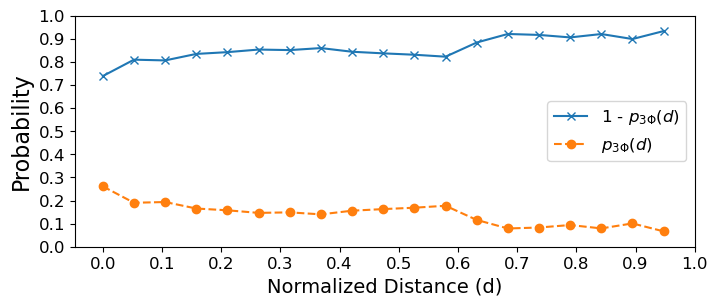

In [16]:
plt.rcParams["figure.figsize"] = (8,3)
plt.plot(prob_3_phases[1].keys(),np.array(list(prob_3_phases[1].values()))+np.array(list(prob_3_phases[2].values())),'x-',label=r'1 - $p_{3\Phi}(d)$')
#plt.plot(prob_3_phases[2].keys(),prob_3_phases[2].values(),label='2')
plt.plot(prob_3_phases[3].keys(),prob_3_phases[3].values(),'o--',label=r'$p_{3\Phi}(d)$')
plt.xlabel(r'Normalized Distance (d)',fontsize=14)
plt.ylabel('Probability',fontsize=16)
plt.legend(fontsize=12,)
plt.xticks(np.linspace(0,1,11),fontsize=12)
plt.yticks(np.linspace(0,1,11),fontsize=12)
plt.show()

## phases ratio

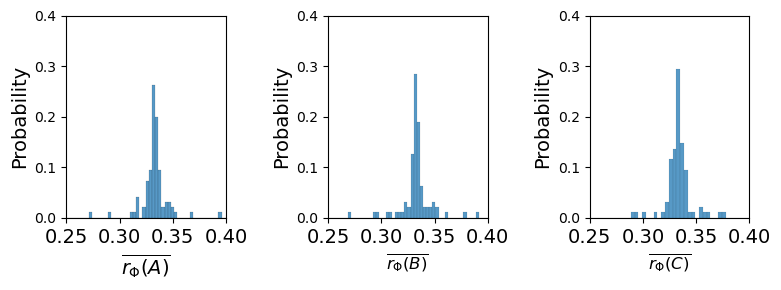

In [9]:
plt.rcParams["figure.figsize"] = (8,3)
ratio_list=[[],[],[]]
for i in range(len(phases_planning)):
    partial_sum=sum(phases_planning[i])
    if(partial_sum!=0):
        ratio_list[0].append(phases_planning[i][0]/partial_sum)
        ratio_list[1].append(phases_planning[i][1]/partial_sum)
        ratio_list[2].append(phases_planning[i][2]/partial_sum)


fig, axs = plt.subplots(1,3)

sns.histplot(ratio_list[0],ax=axs[0],stat='probability')
axs[0].set_ylim([0,0.4])
axs[0].set_xlim([0.25,0.4])
axs[0].set_xticks([0.25,0.3,0.35,0.4])
axs[0].set_xlabel(r'$\overline{r_{\Phi}(A)}$',fontsize=14)

sns.histplot(ratio_list[1],ax=axs[1],stat='probability')
axs[1].set_ylim([0,0.4])
axs[1].set_xlim([0.25,0.4])
axs[1].set_xticks([0.25,0.3,0.35,0.4])
axs[1].set_xlabel(r'$\overline{r_{\Phi}(B)}$',size=12)

sns.histplot(ratio_list[2],ax=axs[2],stat='probability')
axs[2].set_ylim([0,0.4])
axs[2].set_xlim([0.25,0.4])
axs[2].set_xticks([0.25,0.3,0.35,0.4])
axs[2].set_xlabel(r'$\overline{r_{\Phi}(C)}$',size=12)

for ax in axs.flatten():
    ax.set_ylabel('Probability', size=14)
    ax.tick_params(axis='x',labelsize=14)

plt.tight_layout()


# Results part 3 - Model evaluation in georeferenced systems
* step 1: get a graph from a real power system network that you already know the power characteristcs
* step 2: give to the bayesian hierarchical model only the mean values of active and reactive powr 
* step 3: check how close the bayesian model is from the real data of the system

In [4]:
net=pn.ieee_european_lv_asymmetric()
graph_from_net=pp.topology.create_nxgraph(net,include_trafos=False,multi=False)

# defining x and y coordinates for each bus

x_dict={}
y_dict={}

for bus_idx in net.bus.index:
    x_dict[bus_idx]=net.bus_geodata.at[bus_idx,'x']
    y_dict[bus_idx]=net.bus_geodata.at[bus_idx,'y']

nx.set_node_attributes(graph_from_net,x_dict,'x')
nx.set_node_attributes(graph_from_net,y_dict,'y')


# defining the x and y for the gen
bus_gen=0
x_gen=net.bus_geodata.at[bus_gen,'x']
y_gen=net.bus_geodata.at[bus_gen,'y']

#calculating max distance (from a given node to feeder)

max_distance=0
for node in graph_from_net.nodes:
    x=graph_from_net.nodes[node]['x']
    y=graph_from_net.nodes[node]['y']
    distance=np.sqrt((x-x_gen)**2+(y-y_gen)**2)
    if(distance>max_distance):
        max_distance=distance

print(max_distance)

c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pandapower\io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pandapower\io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pandapower\io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
c:\Users\hoc\anacon

156.54072952429985


### Aggregated power 
* saved in aggregated_power_dict

In [5]:
individual_aggregated_power=1000*(np.mean(net.asymmetric_load[net.asymmetric_load.p_a_mw!=0].p_a_mw)+np.mean(net.asymmetric_load[net.asymmetric_load.p_b_mw!=0].p_b_mw)+np.mean(net.asymmetric_load[net.asymmetric_load.p_c_mw!=0].p_c_mw))

individual_aggregated_power=1000*(np.mean(net.asymmetric_load.p_a_mw+net.asymmetric_load.p_b_mw+net.asymmetric_load.p_c_mw))

aggregated_power_dict={}

node_list=list(graph_from_net.nodes)
node_list.sort()



for bus in node_list:
    aggregated_power_dict[bus]=individual_aggregated_power

### Phases proportion and phase choice
* defining as user input to see how the model is able to deal with it
* this phases proportion is only considered for three phase loads


In [6]:
phases_proportion=np.zeros(shape=(len(node_list),3))
p_phases_choice=np.zeros(shape=(len(node_list),3))

for bus in node_list:
    phases_proportion[bus][:]=[0.1,0.6,0.3]
    p_phases_choice[bus][:]=[0.6,0.3,0.1]

NameError: name 'node_list' is not defined

### Variables generated from the combination of gathered data + the input graph
1) phases_line_list: number of phases for each line
2) prob_three_phase_dict: Probability of being 3-phase for each node in the graph

These variables will be used in the bayesian model to generate the samples

In [8]:
phases_line_list=[]
prop_three_phase_dict={}
normalized_dist_dict={}

for u,v in graph_from_net.edges():
    x_line=graph_from_net.nodes[v]['x']
    y_line=graph_from_net.nodes[v]['y']
    distance_from_feeder=np.sqrt((x_line-x_gen)**2+(y_line-y_gen)**2)
    normalized_dist=distance_from_feeder/max_distance
    #print(normalized_dist)
    

    rounded_dist=0
    for distance_key in prob_3_phases[1].keys():
        if(distance_key>normalized_dist):
            rounded_dist=distance_key
            break

    individual_prob_list=np.cumsum([prob_3_phases[1][rounded_dist],prob_3_phases[2][rounded_dist],prob_3_phases[3][rounded_dist]])

    random_number=np.random.rand() #random for line
    if(random_number<=individual_prob_list[0]):
        phases_line_list.append(1)
    elif(random_number<=individual_prob_list[1]):
        phases_line_list.append(2)
    else:
        phases_line_list.append(3)

for u in node_list:
    x_line=graph_from_net.nodes[u]['x']
    y_line=graph_from_net.nodes[u]['y']
    distance_from_feeder=np.sqrt((x_line-x_gen)**2+(y_line-y_gen)**2)
    normalized_dist=distance_from_feeder/max_distance
    normalized_dist_dict[u]=normalized_dist
    #print(normalized_dist)

    rounded_dist=0
    for distance_key in prob_3_phases[1].keys():
        if(distance_key>normalized_dist):
            rounded_dist=distance_key
            break

    #individual_prob_list=np.cumsum([prob_3_phases[1][rounded_dist],prob_3_phases[2][rounded_dist],prob_3_phases[3][rounded_dist]])


    prop_three_phase_dict[u]=prob_3_phases[3][rounded_dist]


In [9]:
mean_user_input_1_phase=np.sum([np.mean([aggregated_power_dict[bus_idx]*phases_proportion[bus_idx][phase_idx] for bus_idx in aggregated_power_dict.keys()]) for phase_idx in range(3)])

mean_user_input_3_phase_a=np.mean([aggregated_power_dict[bus_idx]*phases_proportion[bus_idx][0] for bus_idx in aggregated_power_dict.keys()])
mean_user_input_3_phase_b=np.mean([aggregated_power_dict[bus_idx]*phases_proportion[bus_idx][1] for bus_idx in aggregated_power_dict.keys()])
mean_user_input_3_phase_c=np.mean([aggregated_power_dict[bus_idx]*phases_proportion[bus_idx][2] for bus_idx in aggregated_power_dict.keys()])



mean_power_dict={}
for bus_idx in aggregated_power_dict.keys():
    mean_user_input_1_phase=np.sum([aggregated_power_dict[bus_idx]*p_phases_choice[bus_idx][phase_idx] for phase_idx in range(3)])

    user_input_3_phase_a=aggregated_power_dict[bus_idx]*phases_proportion[bus_idx][0]
    user_input_3_phase_b=aggregated_power_dict[bus_idx]*phases_proportion[bus_idx][1]
    user_input_3_phase_c=aggregated_power_dict[bus_idx]*phases_proportion[bus_idx][2]

    mean_user_input_3_phase=(user_input_3_phase_a+user_input_3_phase_b+user_input_3_phase_c)/3

    mean_power_dict[bus_idx]=prop_three_phase_dict[bus_idx]*mean_user_input_3_phase+(1-prop_three_phase_dict[bus_idx])*mean_user_input_1_phase


overall_mean_power=np.mean(list(mean_power_dict.values()))
overall_mean_power


0.9565400266216528

### Generating ipymc model

In [10]:
#num_single_loads
#num_three_phase_loads
#phases_planning
#phases_proportion

with pm.Model() as three_phase_model:
    feeder_idx=0


    # proportion of each phase
    num_total_loads=len(graph_from_net.nodes)
    #num_total_loads=5
    #num_total_loads=int(num_single_loads[feeder_idx]+num_three_phase_loads[feeder_idx])
    #prop_three_phase=num_three_phase_loads[feeder_idx]/num_total_loads
    prob_three_phases_data=list(prop_three_phase_dict.values())
    #prob_three_phase=0

    three_phase_choice=pm.Bernoulli('three_phase_choice',p=prob_three_phases_data,shape=num_total_loads)



    mu_prop_a=np.mean([phases_proportion[idx][0] for idx in range(len(phases_proportion))])
    #var_prop_a=np.std([phases_proportion[idx][0] for idx in range(len(phases_proportion))])
    #prop_a=pm.TruncatedNormal('prop_a',mu=mu_prop_a,sigma=var_prop_a,shape=num_total_loads,lower=0)

    mu_prop_b=np.mean([phases_proportion[idx][1] for idx in range(len(phases_proportion))])
    #var_prop_b=np.std([phases_proportion[idx][1] for idx in range(len(phases_proportion))])
    #prop_b=pm.TruncatedNormal('prop_b',mu=mu_prop_b,sigma=var_prop_b,shape=num_total_loads,lower=0)

    mu_prop_c=np.mean([phases_proportion[idx][2] for idx in range(len(phases_proportion))])
    #var_prop_c=np.std([phases_proportion[idx][2] for idx in range(len(phases_proportion))])
    #prop_c=pm.TruncatedNormal('prop_c',mu=mu_prop_c,sigma=var_prop_c,shape=num_total_loads,lower=0)

    # phase choice


    phase_choice=pm.Categorical('phase_choice',p=p_phases_choice,shape=(num_total_loads))


    # defining load of each phase
    #mu_p_a=np.mean([phases_planning[idx][0] for idx in range(len(phases_planning))])
    mu_p_a=np.array(list(aggregated_power_dict.values()))
    normalizing_constant=[phases_planning[idx][0] for idx in range(len(phases_planning))]/max([phases_planning[idx][0] for idx in range(len(phases_planning))])
    var_p_a=np.std(normalizing_constant*np.max(list(aggregated_power_dict.values())))
    #expected_p_a=pm.Deterministic('mu_p_a',mu_p_a/(num_total_loads*(prop_three_phase*1/3+(1-prop_three_phase)*prop_a))) #phase a
    p_a=pm.TruncatedNormal('P_a',mu=mu_p_a,sigma=var_p_a,lower=0,shape=(num_total_loads))

    #mu_p_b=np.mean([phases_planning[idx][1] for idx in range(len(phases_planning))])
    mu_p_b=np.array(list(aggregated_power_dict.values()))
    normalizing_constant=[phases_planning[idx][1] for idx in range(len(phases_planning))]/max([phases_planning[idx][1] for idx in range(len(phases_planning))])
    var_p_b=np.std(normalizing_constant*np.max(list(aggregated_power_dict.values())))
    #expected_p_b=pm.Deterministic('mu_p_b',mu_p_b/(num_total_loads*(prop_three_phase*1/3+(1-prop_three_phase)*prop_b))) #phase b
    p_b=pm.TruncatedNormal('P_b',mu=mu_p_b,sigma=var_p_b,lower=0,shape=(num_total_loads))

    #mu_p_c=np.mean([phases_planning[idx][2] for idx in range(len(phases_planning))])
    mu_p_c=np.array(list(aggregated_power_dict.values()))
    normalizing_constant=[phases_planning[idx][2] for idx in range(len(phases_planning))]/max([phases_planning[idx][2] for idx in range(len(phases_planning))])
    var_p_c=np.std(normalizing_constant*np.max(list(aggregated_power_dict.values())))
    #expected_p_c=pm.Deterministic('mu_p_c',mu_p_c/(num_total_loads*(prop_three_phase*1/3+(1-prop_three_phase)*prop_c))) #phase c
    p_c=pm.TruncatedNormal('P_c',mu=mu_p_c,sigma=var_p_c,lower=0,shape=(num_total_loads))


    real_p_a=pm.Deterministic('real_p_a',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 0),p_a,0),p_a*mu_prop_a))
    real_p_b=pm.Deterministic('real_p_b',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 1),p_b,0),p_b*mu_prop_b))
    real_p_c=pm.Deterministic('real_p_c',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 2),p_c,0),p_c*mu_prop_c))



    power_factor_mu=0.95
    power_factor=pm.Beta('power_factor',mu=power_factor_mu,sigma=power_factor_mu*0.05,shape=num_total_loads)

    var_q_a=np.sqrt((var_p_a/power_factor_mu)**2-var_p_a**2)
    var_q_b=np.sqrt((var_p_b/power_factor_mu)**2-var_p_b**2)
    var_q_c=np.sqrt((var_p_c/power_factor_mu)**2-var_p_c**2)

    q_a=pm.TruncatedNormal('Q_a',mu=np.sqrt((mu_p_a/power_factor_mu)**2-mu_p_a**2),sigma=var_q_a,lower=0,shape=(num_total_loads))
    q_b=pm.TruncatedNormal('Q_b',mu=np.sqrt((mu_p_b/power_factor_mu)**2-mu_p_b**2),sigma=var_q_b,lower=0,shape=(num_total_loads))
    q_c=pm.TruncatedNormal('Q_c',mu=np.sqrt((mu_p_c/power_factor_mu)**2-mu_p_c**2),sigma=var_q_c,lower=0,shape=(num_total_loads))

    real_q_a=pm.Deterministic('real_q_a',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 0),q_a,0),q_a*mu_prop_a))
    real_q_b=pm.Deterministic('real_q_b',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 1),q_b,0),q_b*mu_prop_b))
    real_q_c=pm.Deterministic('real_q_c',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 2),q_c,0),q_c*mu_prop_c))

    #phases_planning[feeder_idx]
    #active_power_load=pm.Normal(mu=)

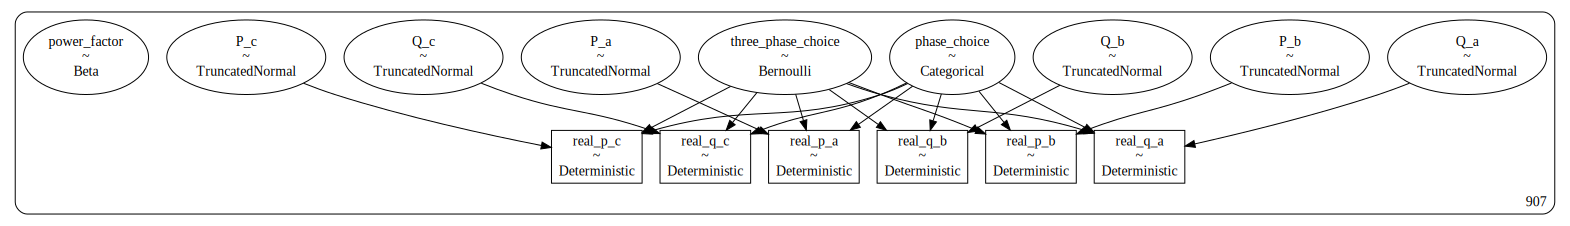

In [11]:
pm.model_to_graphviz(three_phase_model)

In [12]:
with three_phase_model:
    idata = pm.sample(draws=1000,chains=4,tune=10)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [three_phase_choice]
>CategoricalGibbsMetropolis: [phase_choice]
>NUTS: [P_a, P_b, P_c, power_factor, Q_a, Q_b, Q_c]


Sampling 4 chains for 10 tune and 1_000 draw iterations (40 + 4_000 draws total) took 1517 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [14]:
idata

Inference data with groups:
	> posterior
	> sample_stats

# Results part 1 - compared generated samples with input

In [15]:
[num_chains,num_samples,num_loads]=idata.posterior['P_a'].shape

sample_idx=0

df_dict={}

load_list_a=[[] for k_idx in range(num_loads)]
load_list_b=[[] for k_idx in range(num_loads)]
load_list_c=[[] for k_idx in range(num_loads)]

df_dict=pd.DataFrame(columns=['sample_idx','node','p_a','q_a','p_b','q_b','p_c','q_c','num_phases','distance'])
real_p_a_array=copy.deepcopy(idata.posterior['real_p_a'].values)
real_p_b_array=copy.deepcopy(idata.posterior['real_p_b'].values)
real_p_c_array=copy.deepcopy(idata.posterior['real_p_c'].values)
real_q_a_array=copy.deepcopy(idata.posterior['real_q_a'].values)
real_q_b_array=copy.deepcopy(idata.posterior['real_q_b'].values)
real_q_c_array=copy.deepcopy(idata.posterior['real_q_c'].values)
three_phase_choice_array=copy.deepcopy(idata.posterior['three_phase_choice'].values)


for i in range(4): #chains
    print(i)
    for j in range(5): #samples
        for k in range(num_loads):
            distance=normalized_dist_dict[k]
            phase_a_p=float(real_p_a_array[i][j][k])
            phase_a_q=float(real_q_a_array[i][j][k])
            phase_b_p=float(real_p_b_array[i][j][k])
            phase_b_q=float(real_q_b_array[i][j][k])
            phase_c_p=float(real_p_c_array[i][j][k])
            phase_c_q=float(real_q_c_array[i][j][k])
            num_phases=float(three_phase_choice_array[i][j][k])
            df_dict.loc[len(df_dict)]=[sample_idx,k,phase_a_p,phase_a_q,phase_b_p,phase_b_q,phase_c_p,phase_c_q,num_phases,distance]
    
        sample_idx+=1

0
1
2
3


## a) distance x prob_phase

In [16]:
num_points=20 #number of discrete points between 0 and 1
synthetic_3_phase_choice_dict={}
num_nodes_each_distance_dict={}
point_list=np.linspace(0,1,num_points)
for point in range(num_points):
    synthetic_3_phase_choice_dict[point]=0
    num_nodes_each_distance_dict[point]=0

for sample_idx in df_dict.index:
    distance=df_dict.at[sample_idx,'distance']
    num_phases=df_dict.at[sample_idx,'num_phases']
    point_idx=0
    while(point_list[point_idx]<distance):
        point_idx+=1
    synthetic_3_phase_choice_dict[point_idx]+=num_phases
    num_nodes_each_distance_dict[point_idx]+=1

for point_idx in synthetic_3_phase_choice_dict.keys():
    if(synthetic_3_phase_choice_dict[point_idx]!=0):
        synthetic_3_phase_choice_dict[point_idx]/=num_nodes_each_distance_dict[point_idx]


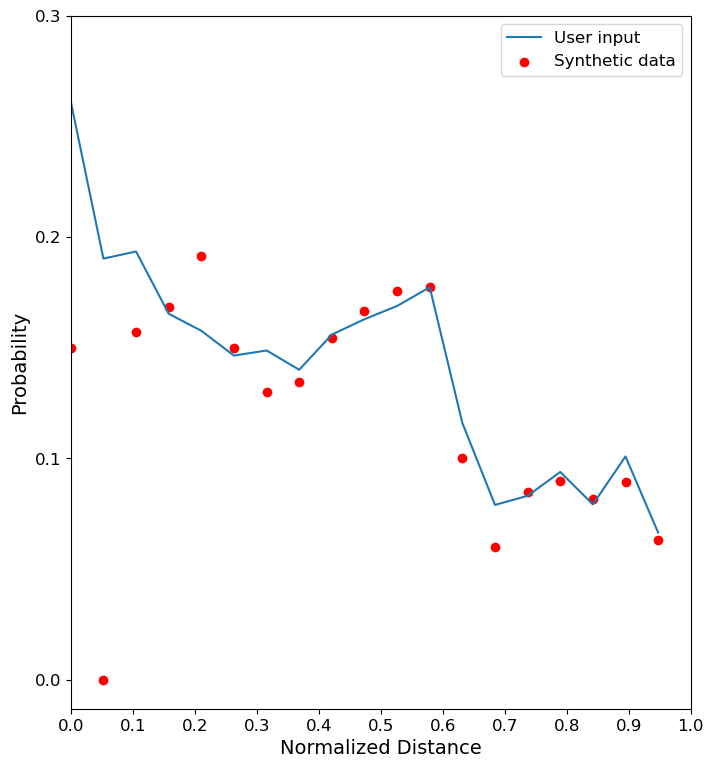

In [18]:
#plt.plot(prob_3_phases[1].keys(),prob_3_phases[1].values(),label='1')
#plt.plot(prob_3_phases[2].keys(),prob_3_phases[2].values(),label='2')
plt.plot(prob_3_phases[3].keys(),prob_3_phases[3].values(),label='User input')
x_axis=[normalized_dist_dict[idx] for idx in node_list]
#plt.scatter(x_axis,prob_three_phases_data,label='generated data',color='red')
plt.scatter(point_list[:-1],list(synthetic_3_phase_choice_dict.values())[:-1],label='Synthetic data',color='red')
plt.xlim([0,0.93])
plt.xlabel('Normalized Distance',fontsize=14)
plt.ylabel('Probability',fontsize=14)
plt.legend(fontsize=12)
plt.xticks(np.linspace(0,1,11),fontsize=12)
plt.yticks(np.linspace(0,0.3,4),fontsize=12)
plt.show()


## b) histplot for active and reactive power
* how does it compare with the aggregated power taken as input
* how does the unbalanced factor compared with real data

## b.1) comparing with the aggregated power - single phase

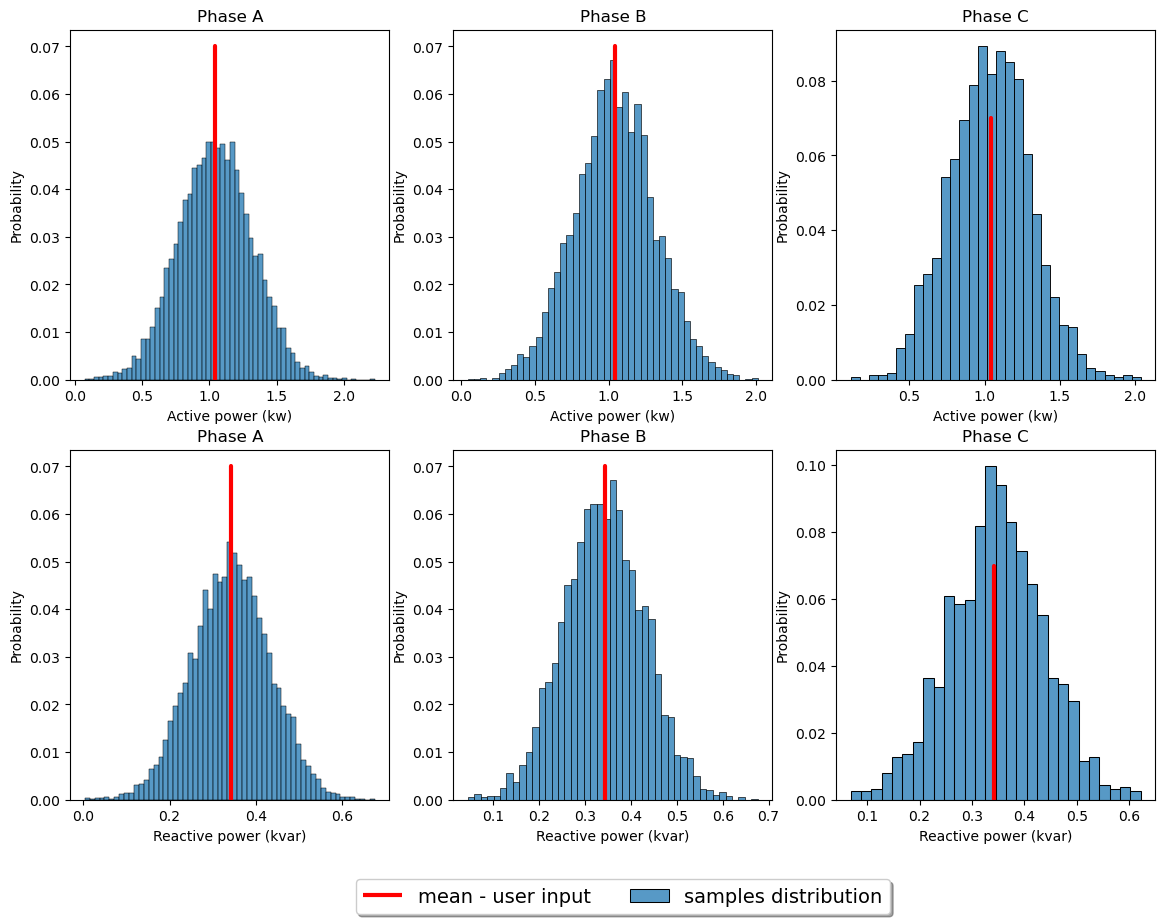

In [24]:
fig,axs=plt.subplots(2,3,figsize=(14,10))


node_idx=0
## active power

#phase A
hist_p_a=df_dict[(df_dict.num_phases==0.0) & (df_dict.p_a!=0)].p_a
sns.histplot(hist_p_a,label='samples distribution',ax=axs[0][0],stat='probability')
axs[0][0].set_xlabel('Active power (kw)')
axs[0][0].set_title('Phase A')
axs[0][0].vlines(np.mean(list(aggregated_power_dict.values())),0,0.07,label='mean - user input',colors='red',linewidth=3)
#axs[0][0].vlines(np.mean(hist_p_a),0,0.07,label='mean - samples',colors='black')

#phase A
hist_p_b=df_dict[(df_dict.num_phases==0.0) & (df_dict.p_b!=0)].p_b
sns.histplot(hist_p_b,label='samples distribution',ax=axs[0][1],stat='probability')
axs[0][1].set_xlabel('Active power (kw)')
axs[0][1].set_title('Phase B')
axs[0][1].vlines(np.mean(list(aggregated_power_dict.values())),0,0.07,label='mean - user input',colors='red',linewidth=3)
#axs[0][1].vlines(np.mean(hist_p_b),0,0.07,label='mean - samples',colors='black')

#phase A
hist_p_c=df_dict[(df_dict.num_phases==0.0) & (df_dict.p_c!=0)].p_c
sns.histplot(hist_p_c,label='samples distribution',ax=axs[0][2],stat='probability')
axs[0][2].set_xlabel('Active power (kw)')
axs[0][2].set_title('Phase C')
axs[0][2].vlines(np.mean(list(aggregated_power_dict.values())),0,0.07,label='mean - user input',colors='red',linewidth=3)
#axs[0][2].vlines(np.mean(hist_p_a),0,0.07,label='mean - samples',colors='black')


## reactive power
power_factor=power_factor_mu

#phase A
hist_q_a=df_dict[(df_dict.num_phases==0.0) & (df_dict.q_a!=0)].q_a
sns.histplot(hist_q_a,label='samples distribution',ax=axs[1][0],stat='probability')
axs[1][0].set_xlabel('Reactive power (kvar)')
axs[1][0].set_title('Phase A')
axs[1][0].vlines(np.mean([np.sqrt((aggregated_power_dict[node_idx]/power_factor)**2-aggregated_power_dict[node_idx]**2) for node_idx in aggregated_power_dict.keys()]),0,0.07,label='mean - user input',colors='red',linewidth=3)
#axs[1][0].vlines(np.mean(hist_q_a),0,0.07,label='mean - samples',colors='black')
#phase B
hist_q_b=df_dict[(df_dict.num_phases==0.0) & (df_dict.p_b!=0)].q_b
sns.histplot(hist_q_b,label='samples distribution',ax=axs[1][1],stat='probability')
axs[1][1].set_xlabel('Reactive power (kvar)')
axs[1][1].set_title('Phase B')
axs[1][1].vlines(np.mean([np.sqrt((aggregated_power_dict[node_idx]/power_factor)**2-aggregated_power_dict[node_idx]**2) for node_idx in aggregated_power_dict.keys()]),0,0.07,label='mean - user input',colors='red',linewidth=3)
#axs[1][1].vlines(np.mean(hist_q_b),0,0.07,label='mean - samples',colors='black')
#phase C
hist_q_c=df_dict[(df_dict.num_phases==0.0) & (df_dict.p_c!=0)].q_c
sns.histplot(hist_q_c,label='samples distribution',ax=axs[1][2],stat='probability')
axs[1][2].set_xlabel('Reactive power (kvar)')
axs[1][2].set_title('Phase C')
axs[1][2].vlines(np.mean([np.sqrt((aggregated_power_dict[node_idx]/power_factor)**2-aggregated_power_dict[node_idx]**2) for node_idx in aggregated_power_dict.keys()]),0,0.07,label='mean - user input',colors='red',linewidth=3)
#axs[1][2].vlines(np.mean(hist_q_c),0,0.07,label='mean - samples',colors='black')



plt.legend(loc='upper right', bbox_to_anchor=(0.2, -0.2),
          fancybox=True, shadow=True, ncol=5,fontsize=14)

plt
plt.show()

## b.2) comparing with the aggregated power - three phase

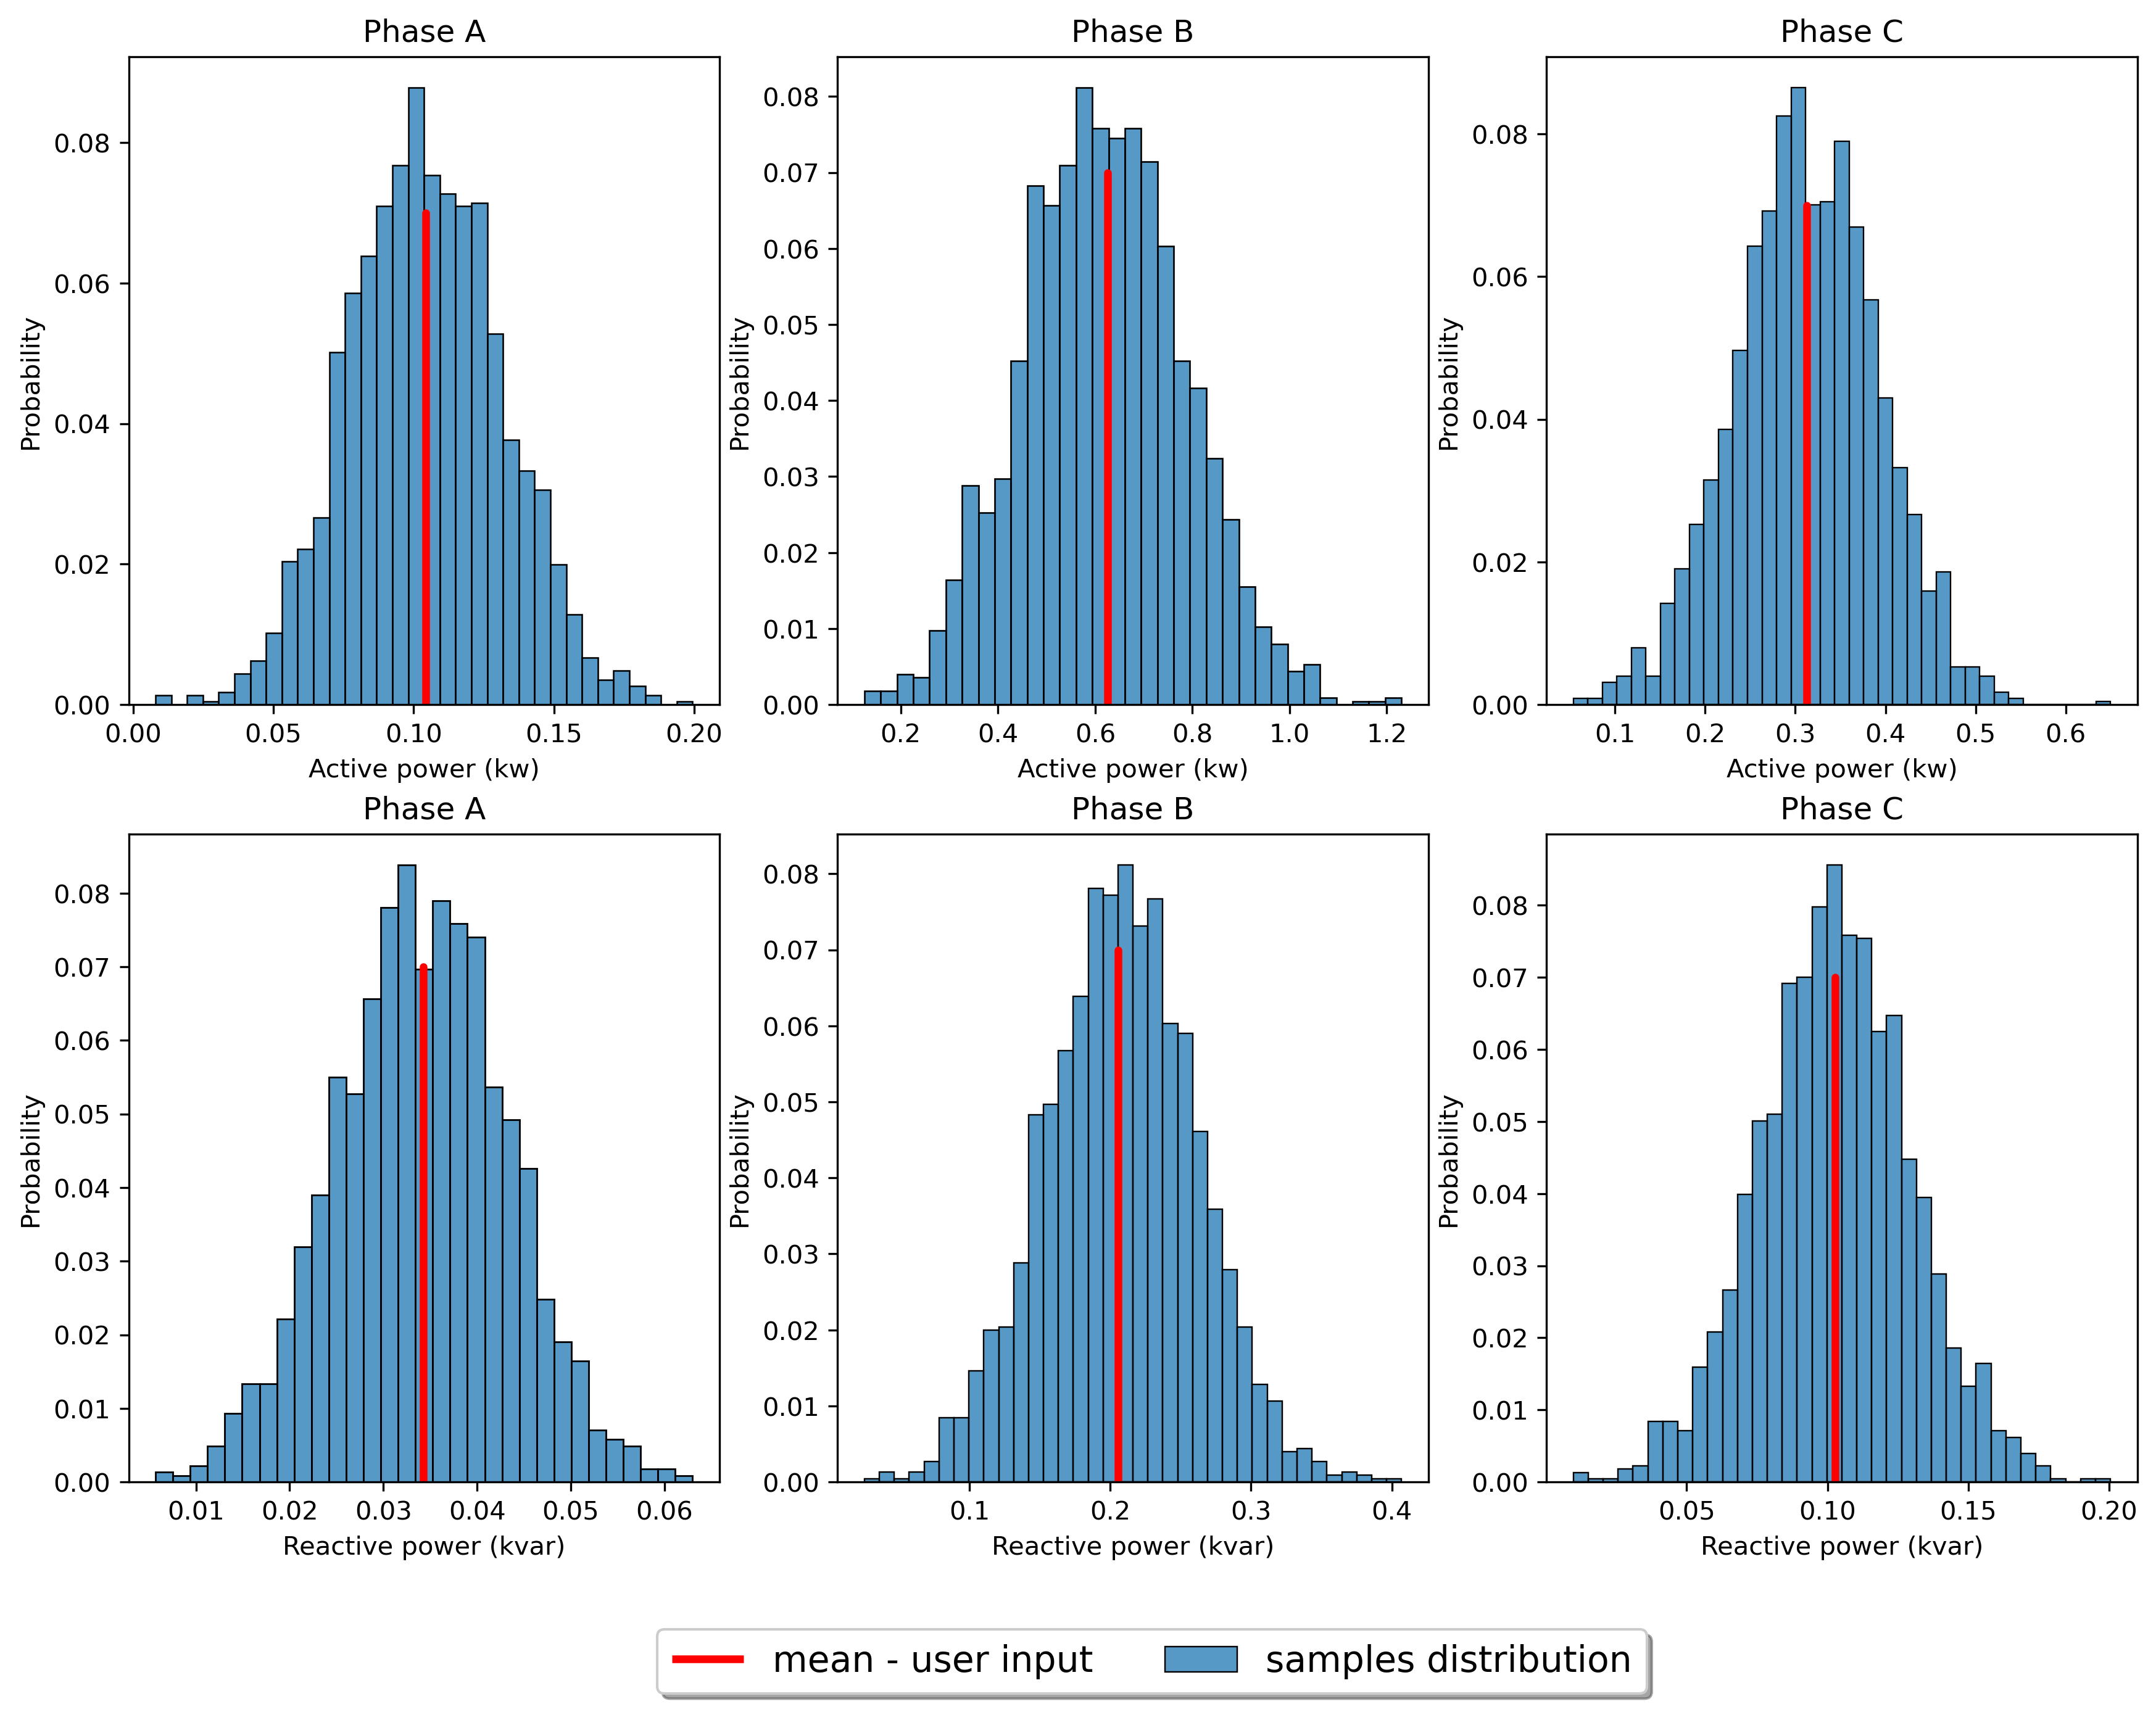

In [25]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

fig,axs=plt.subplots(2,3,figsize=(14,10))


node_idx=0
## active power

#phase A



hist_p_a=df_dict[(df_dict.num_phases==1.0) & (df_dict.p_a!=0)].p_a
sns.histplot(hist_p_a,label='samples distribution',ax=axs[0][0],stat='probability')
axs[0][0].set_xlabel('Active power (kw)')
axs[0][0].set_title('Phase A')
axs[0][0].vlines(mean_user_input_3_phase_a,0,0.07,label='mean - user input',colors='red',linewidth=3)
#axs[0][0].vlines(np.mean(hist_p_a),0,0.07,label='mean - samples',colors='black')

#phase A
hist_p_b=df_dict[(df_dict.num_phases==1.0) & (df_dict.p_b!=0)].p_b
sns.histplot(hist_p_b,label='samples distribution',ax=axs[0][1],stat='probability')
axs[0][1].set_xlabel('Active power (kw)')
axs[0][1].set_title('Phase B')
axs[0][1].vlines(mean_user_input_3_phase_b,0,0.07,label='mean - user input',colors='red',linewidth=3)
#axs[0][1].vlines(np.mean(hist_p_b),0,0.07,label='mean - samples',colors='black')

#phase A
hist_p_c=df_dict[(df_dict.num_phases==1.0) & (df_dict.p_c!=0)].p_c
sns.histplot(hist_p_c,label='samples distribution',ax=axs[0][2],stat='probability')
axs[0][2].set_xlabel('Active power (kw)')
axs[0][2].set_title('Phase C')
axs[0][2].vlines(mean_user_input_3_phase_c,0,0.07,label='mean - user input',colors='red',linewidth=3)
#axs[0][2].vlines(np.mean(hist_p_a),0,0.07,label='mean - samples',colors='black')


## reactive power
power_factor=power_factor_mu

#phase A
hist_q_a=df_dict[(df_dict.num_phases==1.0) & (df_dict.q_a!=0)].q_a
sns.histplot(hist_q_a,label='samples distribution',ax=axs[1][0],stat='probability')
axs[1][0].set_xlabel('Reactive power (kvar)')
axs[1][0].set_title('Phase A')
axs[1][0].vlines(np.mean([np.sqrt((mean_user_input_3_phase_a/power_factor)**2-mean_user_input_3_phase_a**2) for node_idx in aggregated_power_dict.keys()]),0,0.07,label='mean - user input',colors='red',linewidth=3)
#axs[1][0].vlines(np.mean(hist_q_a),0,0.07,label='mean - samples',colors='black')
#phase B
hist_q_b=df_dict[(df_dict.num_phases==1.0) & (df_dict.p_b!=0)].q_b
sns.histplot(hist_q_b,label='samples distribution',ax=axs[1][1],stat='probability')
axs[1][1].set_xlabel('Reactive power (kvar)')
axs[1][1].set_title('Phase B')
axs[1][1].vlines(np.mean([np.sqrt((mean_user_input_3_phase_b/power_factor)**2-mean_user_input_3_phase_b**2) for node_idx in aggregated_power_dict.keys()]),0,0.07,label='mean - user input',colors='red',linewidth=3)
#axs[1][1].vlines(np.mean(hist_q_b),0,0.07,label='mean - samples',colors='black')
#phase C
hist_q_c=df_dict[(df_dict.num_phases==1.0) & (df_dict.p_c!=0)].q_c
sns.histplot(hist_q_c,label='samples distribution',ax=axs[1][2],stat='probability')
axs[1][2].set_xlabel('Reactive power (kvar)')
axs[1][2].set_title('Phase C')
axs[1][2].vlines(np.mean([np.sqrt((mean_user_input_3_phase_c/power_factor)**2-mean_user_input_3_phase_c**2) for node_idx in aggregated_power_dict.keys()]),0,0.07,label='mean - user input',colors='red',linewidth=3)
#axs[1][2].vlines(np.mean(hist_q_c),0,0.07,label='mean - samples',colors='black')



plt.legend(loc='upper right', bbox_to_anchor=(0.2, -0.2),
          fancybox=True, shadow=True, ncol=5,fontsize=14)

plt.show()

# b.2) comparing the means: user input versus generated samples (for each node)

In [204]:
user_input_p=[]
user_input_q=[]
power_data_df=pd.DataFrame(columns=['source','power_type','phase','value'])


user_input_p_a_list=[]
for node_idx in graph_from_net.nodes:
    p_a=np.mean(df_dict[(df_dict.node==node_idx) & (df_dict.num_phases==1.0) & (df_dict.p_a!=0)].p_a)
    q_a=np.mean(df_dict[(df_dict.node==node_idx) & (df_dict.num_phases==1.0) & (df_dict.p_a!=0)].q_a)
    p_b=np.mean(df_dict[(df_dict.node==node_idx) & (df_dict.num_phases==1.0) & (df_dict.p_b!=0)].p_b)
    q_b=np.mean(df_dict[(df_dict.node==node_idx) & (df_dict.num_phases==1.0) & (df_dict.p_b!=0)].q_b)
    p_c=np.mean(df_dict[(df_dict.node==node_idx) & (df_dict.num_phases==1.0) & (df_dict.p_c!=0)].p_c)
    q_c=np.mean(df_dict[(df_dict.node==node_idx) & (df_dict.num_phases==1.0) & (df_dict.p_c!=0)].q_c)

    user_input_p_a=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].p_a_mw)
    user_input_p_b=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].p_b_mw)
    user_input_p_c=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].p_c_mw)
    user_input_q_a=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].q_a_mvar)
    user_input_q_b=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].q_b_mvar)
    user_input_q_c=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].q_c_mvar)

    #real data
    power_data_df.loc[len(power_data_df)]=['real_data','p','a',p_a]
    power_data_df.loc[len(power_data_df)]=['real_data','q','b',q_a]
    power_data_df.loc[len(power_data_df)]=['real_data','p','c',p_b]
    power_data_df.loc[len(power_data_df)]=['real_data','q','a',q_b]
    power_data_df.loc[len(power_data_df)]=['real_data','p','b',p_c]
    power_data_df.loc[len(power_data_df)]=['real_data','q','c',q_c]
    
    #user input
    if(user_input_p_a!=0):
        user_input_p_a_list.append(user_input_p_a)
        power_data_df.loc[len(power_data_df)]=['user_input','p','a',user_input_p_a]
    if(user_input_p_b!=0):
        power_data_df.loc[len(power_data_df)]=['user_input','p','b',user_input_p_b]
    if(user_input_p_c!=0):
        power_data_df.loc[len(power_data_df)]=['user_input','p','c',user_input_p_c]
    if(user_input_q_a!=0):
        power_data_df.loc[len(power_data_df)]=['user_input','q','a',user_input_q_a]
    if(user_input_q_b!=0):
        power_data_df.loc[len(power_data_df)]=['user_input','q','b',user_input_q_b]
    if(user_input_q_c!=0):
        power_data_df.loc[len(power_data_df)]=['user_input','q','c',user_input_q_c]


<Axes: xlabel='phase', ylabel='value'>

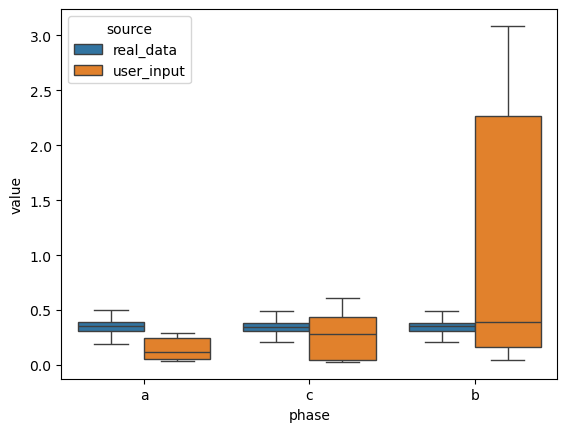

In [205]:
sns.boxplot(power_data_df[power_data_df.power_type=='p'],x='phase',y='value',hue='source',showfliers = False)

<Axes: xlabel='source', ylabel='value'>

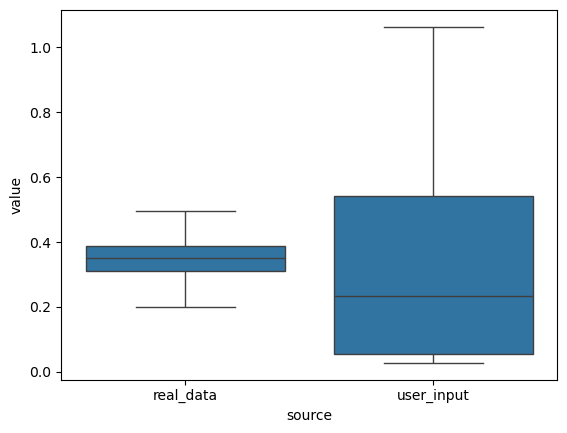

In [207]:
sns.boxplot(power_data_df[power_data_df.power_type=='p'],x='source',y='value',showfliers = False)

<Axes: xlabel='source', ylabel='value'>

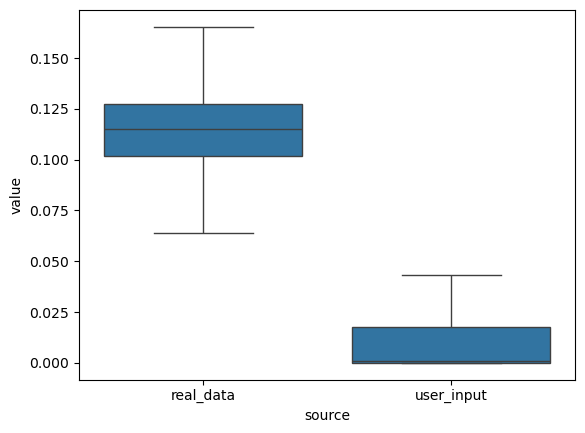

In [208]:
sns.boxplot(power_data_df[power_data_df.power_type=='q'],x='source',y='value',showfliers = False)

## b.3) doing without filtering 3-phase and single phase

In [224]:
user_input_p=[]
user_input_q=[]
power_data_df=pd.DataFrame(columns=['source','power_type','phase','value'])
error_dict={'p_a':[],
            'p_b':[],
            'p_c':[],
            'q_a':[],
            'q_b':[],
            'q_c':[],
            }


user_input_p_a_list=[]
for node_idx in graph_from_net.nodes:
    p_a=np.mean(df_dict[(df_dict.node==node_idx)].p_a)
    q_a=np.mean(df_dict[(df_dict.node==node_idx)].q_a)
    p_b=np.mean(df_dict[(df_dict.node==node_idx)].p_b)
    q_b=np.mean(df_dict[(df_dict.node==node_idx)].q_b)
    p_c=np.mean(df_dict[(df_dict.node==node_idx)].p_c)
    q_c=np.mean(df_dict[(df_dict.node==node_idx)].q_c)

    user_input_p_a=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].p_a_mw)
    user_input_p_b=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].p_b_mw)
    user_input_p_c=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].p_c_mw)
    user_input_q_a=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].q_a_mvar)
    user_input_q_b=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].q_b_mvar)
    user_input_q_c=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].q_c_mvar)

    #real data
    power_data_df.loc[len(power_data_df)]=['model','p','a',p_a]
    power_data_df.loc[len(power_data_df)]=['model','q','b',q_a]
    power_data_df.loc[len(power_data_df)]=['model','p','c',p_b]
    power_data_df.loc[len(power_data_df)]=['model','q','a',q_b]
    power_data_df.loc[len(power_data_df)]=['model','p','b',p_c]
    power_data_df.loc[len(power_data_df)]=['model','q','c',q_c]


    
    #user input
    if(user_input_p_a!=0):
        user_input_p_a_list.append(user_input_p_a)
        error_dict['p_a'].append(np.abs(((p_a-user_input_p_a)/user_input_p_a)))
        power_data_df.loc[len(power_data_df)]=['user_input','p','a',user_input_p_a]
    if(user_input_p_b!=0):
        power_data_df.loc[len(power_data_df)]=['user_input','p','b',user_input_p_b]
        error_dict['p_b'].append(np.abs(((p_b-user_input_p_b)/user_input_p_b)))
    if(user_input_p_c!=0):
        power_data_df.loc[len(power_data_df)]=['user_input','p','c',user_input_p_c]
        error_dict['p_c'].append(np.abs(((p_c-user_input_p_c)/user_input_p_c)))
    if(user_input_q_a!=0):
        power_data_df.loc[len(power_data_df)]=['user_input','q','a',user_input_q_a]
        error_dict['q_a'].append(np.abs(((q_a-user_input_q_a)/user_input_q_a)))
    if(user_input_q_b!=0):
        power_data_df.loc[len(power_data_df)]=['user_input','q','b',user_input_q_b]
        error_dict['q_b'].append(np.abs(((q_b-user_input_q_b)/user_input_q_b)))
    if(user_input_q_c!=0):
        power_data_df.loc[len(power_data_df)]=['user_input','q','c',user_input_q_c]
        error_dict['q_c'].append(np.abs(((q_c-user_input_q_c)/user_input_q_c)))

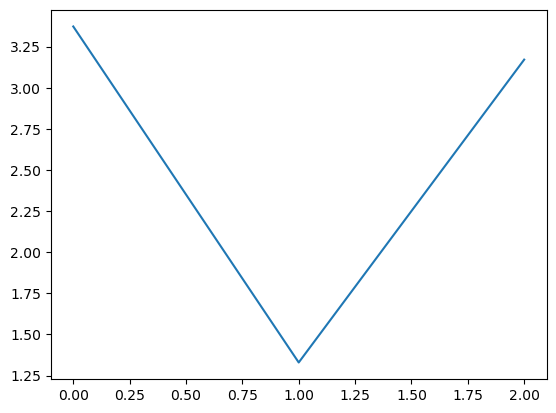

In [232]:
plt.plot([np.mean(error_dict[key]) for key in ['p_a','p_b','p_c']])

<Axes: xlabel='phase', ylabel='value'>

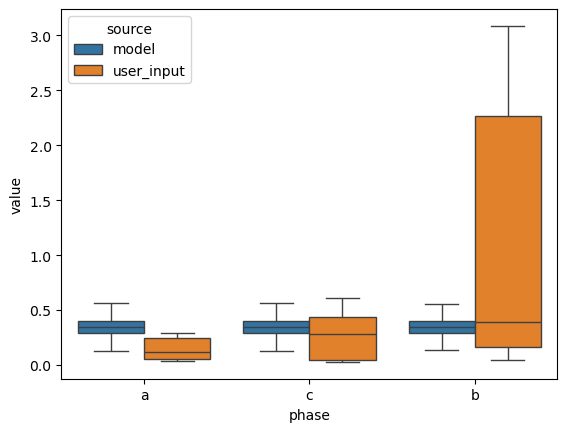

In [212]:
sns.boxplot(power_data_df[power_data_df.power_type=='p'],x='phase',y='value',hue='source',showfliers = False)

<Axes: xlabel='source', ylabel='value'>

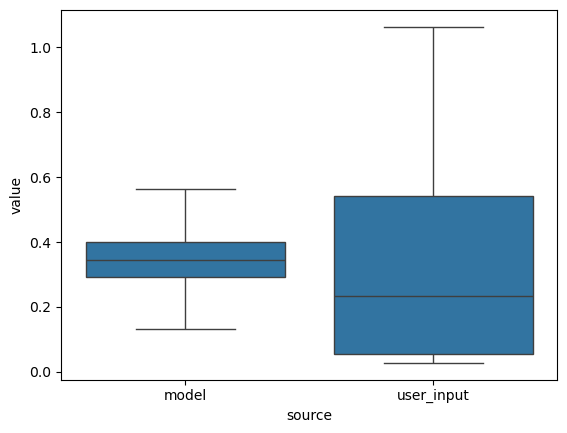

In [213]:
sns.boxplot(power_data_df[power_data_df.power_type=='p'],x='source',y='value',showfliers = False)

In [218]:
power_data_df.head()

,source,power_type,phase,value
0,model,p,a,0.178141
1,model,q,b,0.068335
2,model,p,c,0.321456
3,model,q,a,0.097595
4,model,p,b,0.491516


# Results part 4 - Checking a more unbalanced power system (IEEE123)
* present a smaller system where we show the network topology in the paper and color code the nodes and lines which were decided to be phase, A, B, or C and combination of them. 

In [2]:
dss.Command(r'Redirect C:\Users\hoc\Documents\Henrique\Doutorado\codigos_linux\dev\phd\papers\artigo_3_phase_synthetic\ieee123\IEEE123Master.dss')


In [3]:
loads_df=dss.utils.loads_to_dataframe()
lines_df=dss.utils.lines_to_dataframe()

In [4]:
pp_123=pp.create_empty_network()

closed_switch_list=['sw'+str(i) for i in range(2,6)]
for line_idx in lines_df.index:
    if(line_idx[0]=='l' or line_idx in closed_switch_list):
        bus_1=lines_df.at[line_idx,'Bus1'].split('.')[0]
        bus_2=lines_df.at[line_idx,'Bus2'].split('.')[0]
        if(bus_1[-1]=='r'):
            bus_1=bus_1[:-1]
            #print(bus_1)
        bus_1_int=int(bus_1)

        if(bus_2[-1]=='r'):
            bus_2=bus_2[:-1]
        bus_2_int=int(bus_2)
        phases=lines_df.at[line_idx,'Phases']
        comprimento=lines_df.at[line_idx,'Length']
        #print(pp_123.bus.name)
        if(bus_1 not in list(pp_123.bus.name)):
            #print(bus_1)
            pp.create_bus(pp_123,name=bus_1,vn_kv=5)

        if(bus_2 not in list(pp_123.bus.name)):
            pp.create_bus(pp_123,name=bus_2,vn_kv=5)
        bus_1_idx=pp_123.bus[pp_123.bus.name==bus_1].index[0]
        bus_2_idx=pp_123.bus[pp_123.bus.name==bus_2].index[0]

        pp.create_line(net=pp_123,name=line_idx,from_bus=bus_1_idx,to_bus=bus_2_idx,length_km=comprimento,std_type='NAYY 4x50 SE')

In [5]:

for load_idx in loads_df.index:
    num_phase=loads_df.at[load_idx,'Phases']
    if(num_phase==1):
        load_bus_idx=int(load_idx[1:-1])-1
        phase=load_idx[-1]
    else: # 3 phases
        load_bus_idx=int(load_idx[1:])-1
    vn_kv=loads_df.at[load_idx,'kV']
    
    active_power=1e-3*loads_df.at[load_idx,'kW']
    reactive_power=1e-3*loads_df.at[load_idx,'kvar']
    
    pp.create_load(pp_123,bus=load_bus_idx,p_mw=active_power,q_mvar=reactive_power)
    pp_123.bus.at[load_bus_idx,'vn_kv']=vn_kv

### 123 system - georeferenced position for buses

In [6]:
file_path='ieee123\BusCoords.dat'
geo_data_df=pd.DataFrame(columns=['bus_idx','x','y'])
geo_data_dict={}


with open(file_path, 'r') as file:
    for line in file:
        #print('line', line)
        line_split=line.split('     ')
        bus_name=line_split[0]
        bus_idx_list=pp_123.bus[pp_123.bus.name==bus_name].index
        if(len(bus_idx_list)!=0):
            bus_idx=bus_idx_list[0]
            x=int(line_split[1])
            y=int(line_split[2][:-1])
            #print(bus_name,bus_idx,x,y)
            geo_data_df.loc[len(geo_data_df)]=[bus_idx,y,x]
            geo_data_dict[bus_idx]=[x,y]


### generating synthetic data for pp 123


In [7]:
net=copy.deepcopy(pp_123)
graph_from_net=pp.topology.create_nxgraph(net,include_trafos=False,multi=False)

# defining x and y coordinates for each bus

x_dict={}
y_dict={}

for bus_idx in net.bus.index:
    x_dict[bus_idx]=geo_data_dict[bus_idx][0]
    y_dict[bus_idx]=geo_data_dict[bus_idx][1]

nx.set_node_attributes(graph_from_net,x_dict,'x')
nx.set_node_attributes(graph_from_net,y_dict,'y')


# defining the x and y for the gen
bus_gen=0
x_gen=geo_data_dict[0][0]
y_gen=geo_data_dict[0][1]

#calculating max distance (from a given node to feeder)

max_distance=0
for node in graph_from_net.nodes:
    x=graph_from_net.nodes[node]['x']
    y=graph_from_net.nodes[node]['y']
    distance=np.sqrt((x-x_gen)**2+(y-y_gen)**2)
    if(distance>max_distance):
        max_distance=distance

print(max_distance)



### stop here
node_list=list(graph_from_net.nodes)
node_list.sort()


individual_aggregated_power=1000*np.mean(pp_123.load.p_mw)
aggregated_power_dict={}

node_list=list(graph_from_net.nodes)
node_list.sort()



for bus in node_list:
    aggregated_power_dict[bus]=individual_aggregated_power

phases_proportion=np.zeros(shape=(len(node_list),3))
p_phases_choice=np.zeros(shape=(len(node_list),3))

for bus in node_list:
    phases_proportion[bus][:]=[1/3,1/3,1/3]
    p_phases_choice[bus][:]=[1/3,1/3,1/3]

### stop here



5184.833652104954


In [8]:
phases_line_list=[]
priori_prop_three_phase_dict={}
normalized_dist_dict={}
node_list=list(graph_from_net.nodes)
node_list.sort()

x_gen=geo_data_dict[0][0]
y_gen=geo_data_dict[0][1]


for u,v in graph_from_net.edges():
    x_line=geo_data_dict[u][0]
    y_line=geo_data_dict[u][1]
    distance_from_feeder=np.sqrt((x_line-x_gen)**2+(y_line-y_gen)**2)
    normalized_dist=distance_from_feeder/max_distance
    

    rounded_dist=0
    for distance_key in prob_3_phases[1].keys():
        if(distance_key>normalized_dist):
            rounded_dist=distance_key
            break

    individual_prob_list=np.cumsum([prob_3_phases[1][rounded_dist],prob_3_phases[2][rounded_dist],prob_3_phases[3][rounded_dist]])

    random_number=np.random.rand() #random for line
    if(random_number<=individual_prob_list[0]):
        phases_line_list.append(1)
    elif(random_number<=individual_prob_list[1]):
        phases_line_list.append(2)
    else:
        phases_line_list.append(3)

for u in node_list:
    x_line=geo_data_dict[u][0]
    y_line=geo_data_dict[u][1]
    distance_from_feeder=np.sqrt((x_line-x_gen)**2+(y_line-y_gen)**2)
    normalized_dist=distance_from_feeder/max_distance
    normalized_dist_dict[u]=normalized_dist
    #print(normalized_dist)

    rounded_dist=0
    for distance_key in prob_3_phases[1].keys():
        if(distance_key>normalized_dist):
            rounded_dist=distance_key
            break

    #individual_prob_list=np.cumsum([prob_3_phases[1][rounded_dist],prob_3_phases[2][rounded_dist],prob_3_phases[3][rounded_dist]])


    priori_prop_three_phase_dict[u]=prob_3_phases[3][rounded_dist]

NameError: name 'prob_3_phases' is not defined

In [12]:
three_phase_model=generate_3_phase_model(graph_from_net,aggregated_power_dict,priori_prop_three_phase_dict,phases_proportion,p_phases_choice)

In [33]:
with three_phase_model:
    idata = pm.sample(draws=1000,chains=4,tune=100)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [three_phase_choice]
>CategoricalGibbsMetropolis: [phase_choice]
>NUTS: [P_a, P_b, P_c, power_factor, Q_a, Q_b, Q_c]


Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 159 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Checking phase consistency

In [34]:
best_num_value=-1
best_num_index=None

for trace_idx in range(4):
    for sample_idx in range(100):
        three_phase_choice_dict={}
        for bus_idx in pp_123.bus.index:
            three_phase_choice_dict[bus_idx]=idata.posterior['three_phase_choice'].values[trace_idx,sample_idx,bus_idx]

        feeder_idx=0
        for bus_idx in pp_123.bus.index:
            full_path=nx.shortest_path(graph_from_net,feeder_idx,bus_idx)

            occured_single_phase=False
            for path_node in full_path:
                num_phase=three_phase_choice_dict[path_node]
                if(num_phase==0): # single phase
                    occured_single_phase=True
                elif(num_phase==1 and occured_single_phase):
                    three_phase_choice_dict[path_node]=0
        if(sum(three_phase_choice_dict.values())>best_num_value):
            best_num_value=sum(three_phase_choice_dict.values())
            best_three_phase_dict=three_phase_choice_dict
    




In [265]:

best_score=1e9
feeder_idx=0
for trace_idx in range(4):
    for sample_idx in range(100):
        phase_choice_dict={}
        reverse_bus_list=list(pp_123.bus.index)
        reverse_bus_list.reverse()
        for bus_idx in pp_123.bus.index:
            phase_choice_dict[bus_idx]=[idata.posterior['phase_choice'].values[0,sample_idx,bus_idx]]
        
        for j in range(3):
            for bus_idx in reverse_bus_list:
                if(feeder_idx!=bus_idx):
                    full_path=nx.shortest_path(graph_from_net,feeder_idx,bus_idx)
                    #print(full_path)
                    prior_path=[phase_choice_dict[path_bus] for path_bus in full_path]
                    #for path_idx in range(len(prior_path)):
                    #print('antes',prior_path)
                    for path_idx in range(2,len(prior_path)+1):
                        phases_parent=prior_path[-path_idx]
                        phases_child=prior_path[-(path_idx-1)]
                        #print('parent: {}, child:{}'.format(phases_parent,phases_child))
                        if(phases_parent!=phases_child):
                            intersection_phases=list(set(phases_parent+phases_child))
                            if(len(intersection_phases)<3 and (len(phases_parent)>=len(phases_child))): # allow for one more phase
                                prior_path[-(path_idx)]=intersection_phases
                            else: # do not allow for one more phase -> restrict everything from feeder to parent
                                #print('eae')
                                for path_idx_2 in range(len(prior_path[:-(path_idx-1)])):
                                    prior_path[path_idx_2]=intersection_phases
                    #print('depois',prior_path)
                    for path_idx in range(len(full_path)):
                        path_node=full_path[path_idx]
                        phase_choice_dict[path_node]=prior_path[path_idx]

        score=sum([len(i) for i in phase_choice_dict.values()])
        if(score<best_score):
            print(score)
            best_score=score
            best_phase_choice_dict=copy.deepcopy(phase_choice_dict)


240
237
227


In [266]:
num_phases_lines={}
feeder_idx=0
line_idx=0
for (bus_1,bus_2) in graph_from_net.edges:
    path_bus_1=nx.shortest_path_length(graph_from_net,0,bus_1)
    path_bus_2=nx.shortest_path_length(graph_from_net,0,bus_2)
    if(path_bus_1>=path_bus_2):
        num_phases_lines[line_idx]=len(best_phase_choice_dict[bus_1])
    else:
        num_phases_lines[line_idx]=len(best_phase_choice_dict[bus_2])
    line_idx+=1

In [267]:
import matplotlib
cmap_blue = matplotlib.colormaps['Blues']
cmap_red = matplotlib.colormaps['Reds']
cmap_green = matplotlib.colormaps['Greens']

phase_choice_dict={}
three_phase_choice_dict={}

node_color_map=[]
node_labels_dict={}
edge_color_map=[]
sample_idx=10
cmap_value=0.5

for bus_idx in pp_123.bus.index:
    #phase_choice_dict[bus_idx]=idata.posterior['phase_choice'].values[0,sample_idx,bus_idx]
    #three_phase_choice_dict[bus_idx]=idata.posterior['three_phase_choice'].values[0,sample_idx,bus_idx]
    three_phase_choice_dict[bus_idx]=best_three_phase_dict[bus_idx]
    phase_choice_dict[bus_idx]=best_phase_choice_dict[bus_idx]

    if(bus_idx==0):
        node_color_map.append('black')
        node_labels_dict[bus_idx]=''
    elif(three_phase_choice_dict[bus_idx]==1): # three phase -> red
        node_color_map.append('w')
        node_labels_dict[bus_idx]=r'$3$'
    else: # single phase -> blue
        node_labels_dict[bus_idx]=''
        if(0 in phase_choice_dict[bus_idx]):
            node_labels_dict[bus_idx]+='A'
        if(1 in phase_choice_dict[bus_idx]):
            node_labels_dict[bus_idx]+='B'
        if(2 in phase_choice_dict[bus_idx]):
            node_labels_dict[bus_idx]+='C'

        if(node_labels_dict[bus_idx]=='A'):
            node_color_map.append('r')
        elif(node_labels_dict[bus_idx]=='B'):
            node_color_map.append('g')
        elif(node_labels_dict[bus_idx]=='C'):
            node_color_map.append('b')
        elif(node_labels_dict[bus_idx]=='BC'):
            node_color_map.append('c')
        elif(node_labels_dict[bus_idx]=='AC'):
            node_color_map.append('m')
        elif(node_labels_dict[bus_idx]=='AB'):
            node_color_map.append('y')
        else:
            node_color_map.append('w')
            node_labels_dict[bus_idx]=r'$3$'


for line_idx in pp_123.line.index:
    if(num_phases_lines[line_idx]==1):
        edge_color_map.append(cmap_blue(cmap_value))
    elif(num_phases_lines[line_idx]==2):
        edge_color_map.append(cmap_green(cmap_value))
    else:
        edge_color_map.append(cmap_red(cmap_value))

In [9]:
node_labels_dict_2={}
for node_idx in graph_from_net.nodes:
    node_labels_dict_2[node_idx]=node_idx

In [10]:
geo_data_dict_2=copy.deepcopy(geo_data_dict)
to_up_list=[114,39,37,40,41,111,113,115,116]
to_down_list=[90,91,92,93,94,95,96,97,98,99,81,17,18,19,3,5,6,7]
to_left_list=[82,83,84,85,86,87,88,89]
to_right_list=[15,12,16,10,8,9,4,1,2,0,3,5,6,7,53]
alpha_factor=500

for node in to_up_list:
    geo_data_dict_2[node][1]+=150
for node in to_down_list:
    geo_data_dict_2[node][1]-=alpha_factor
for node in to_right_list:
    geo_data_dict_2[node][0]-=500
for node in to_left_list:
    geo_data_dict_2[node][0]+=alpha_factor

for node in [18,17,13,11,14,21,24,26,28]:
    geo_data_dict_2[node][0]-=200

for node in [64,65,66,67,68]:
    geo_data_dict_2[node][1]+=200
    geo_data_dict_2[node][0]+=200
    

for node in [29,27,30,31,35]:
    geo_data_dict_2[node][0]-=200

geo_data_dict_2[61][0]-=200
geo_data_dict_2[20][0]-=200
geo_data_dict_2[22][0]-=200
geo_data_dict_2[104][1]+=70
geo_data_dict_2[54][0]-=140
geo_data_dict_2[55][0]-=140
geo_data_dict_2[49][0]-=140


In [14]:
pp.to_pickle(net,filename='ieee123_pp.p')

In [16]:
save_pickle(geo_data_dict_2,'geo_data_ieee123.pickle')

In [270]:
#for node in [14,21,24,26,28,32]:
#    node_color_map[node]='w'

In [11]:
from matplotlib.lines import Line2D
from matplotlib.patches import Circle
plt.rcParams["figure.figsize"] = (8,7)

#edge_color_map

nodes = nx.draw_networkx_nodes(graph_from_net, pos=geo_data_dict_2,node_size=100,node_color=node_color_map,alpha=1,
                               label=list(graph_from_net.nodes))
nodes.set_edgecolor('k')
#nx.draw_networkx_labels(graph_from_net, pos=geo_data_dict_2, labels = node_labels_dict_2)
nx.draw_networkx_edges(graph_from_net, pos=geo_data_dict_2,edge_color='black')
#nx.draw(graph_from_net, pos=geo_data_dict,node_size=120,node_color=node_color_map,
#       edge_color='black',width=1,font_size=9,font_color='black',alpha=1)

#handles = [Line2D([], [], color=color, label=label)
#           for color, label in zip([cmap_blue(cmap_value),cmap_green(cmap_value),cmap_red(cmap_value)], ["1 Phase line", "2 Phase line", "3 Phase line"])]
handles=[]
handles.append(Circle(0,color='r',label='A'))
handles.append(Circle(0,color='g',label='B'))
handles.append(Circle(0,color='b',label='C'))
handles.append(Circle(0,color='c',label='BC'))
handles.append(Circle(0,color='m',label='AC'))
handles.append(Circle(0,color='y',label='AB'))
handles.append(Circle(0,color='w',label='ABC'))
handles.append(Circle(0,color='k',label='Feeder'))

plt.legend(handles=handles,ncols=3,facecolor='lightgrey')
plt.box(False)
plt.show()

NameError: name 'node_color_map' is not defined